In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
!pip install lib/kaggle-rig-0.2.0.tar.gz
import krig
krig.seed_everything()

Processing ./lib/kaggle-rig-0.2.0.tar.gz
  Created wheel for kaggle-rig: filename=kaggle_rig-0.2.0-py3-none-any.whl size=6539 sha256=33b13272dca5d90edf6ba6771c2470f7e57e29cd03b8b3363c27332aead3b746
  Stored in directory: /home/pankun/.cache/pip/wheels/03/99/72/07676e0abd65551d5261aee9360ad1c85fcaca1c409857a40a
Successfully built kaggle-rig
  Attempting uninstall: kaggle-rig
    Found existing installation: kaggle-rig 0.2.0
    Uninstalling kaggle-rig-0.2.0:
      Successfully uninstalled kaggle-rig-0.2.0


In [3]:
FOLDS = 10
DATA = 'input/processed'
TARGET = ['fvc_last_3', 'fvc_last_2', 'fvc_last_1']
NON_FEATURES = set(TARGET) | {'pid', 'week_last_1', 'week_last_2', 'week_last_3'}
CATEGORICALS = {'sex', 'smoking'}
SCORING = 'neg_root_mean_squared_error'

In [4]:
# Characters such as empty strings '' or numpy.inf are considered NA values
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
sns.set(style="whitegrid")

In [5]:
train = pd.read_parquet(f'{DATA}/cvtrain.parquet')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pid                    174 non-null    object 
 1   age                    174 non-null    uint8  
 2   sex                    174 non-null    object 
 3   smoking                174 non-null    object 
 4   week_1                 174 non-null    int16  
 5   fvc_1                  174 non-null    uint16 
 6   percent_1              174 non-null    float32
 7   fvc_last_1             174 non-null    uint16 
 8   fvc_last_2             174 non-null    uint16 
 9   fvc_last_3             174 non-null    uint16 
 10  week_last_1            174 non-null    int16  
 11  week_last_2            174 non-null    int16  
 12  week_last_3            174 non-null    int16  
 13  fvc_last_1_min         174 non-null    float32
 14  fvc_last_1_p50         174 non-null    float32
 15  fvc_la

In [6]:
train.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,fvc_last_1_min,fvc_last_1_p50,fvc_last_1_p75,fvc_last_1_p90,fvc_last_1_p95,fvc_last_1_p99,fvc_last_1_max,fvc_last_2_min,fvc_last_2_p50,fvc_last_2_p75,fvc_last_2_p90,fvc_last_2_p95,fvc_last_2_p99,fvc_last_2_max,fvc_last_3_min,fvc_last_3_p50,fvc_last_3_p75,fvc_last_3_p90,fvc_last_3_p95,fvc_last_3_p99,fvc_last_3_max,lung_area_min,lung_area_p50,lung_area_p75,lung_area_p90,lung_area_p95,lung_area_p99,lung_area_max,tissue_area_min,tissue_area_p50,tissue_area_p75,tissue_area_p90,tissue_area_p95,tissue_area_p99,tissue_area_max,lung_tissue_ratio_min,lung_tissue_ratio_p50,lung_tissue_ratio_p75,lung_tissue_ratio_p90,lung_tissue_ratio_p95,lung_tissue_ratio_p99,lung_tissue_ratio_max
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,2094.842529,2379.502686,2504.652832,2600.577881,2607.569824,2656.259033,2675.425537,2097.820312,2380.599609,2505.168457,2600.144775,2607.181641,2656.097412,2675.457520,2101.231201,2382.506348,2505.515625,2600.043701,2607.007080,2655.563232,2674.792969,670.0,1656.0,2391.25,2693.100098,2721.350098,2828.399902,2869.0,4255.0,6106.0,9372.75,11325.299805,12560.299805,13245.419922,13333.0,0.059491,0.256664,0.446996,0.568525,0.573278,0.626535,0.647630
1,ID00009637202177434476278,69,Male,Ex-smoker,8,3660,85.282875,3214,3390,3625,60,45,33,2400.511475,2958.102051,3091.000488,3166.162109,3222.469482,3319.070801,3450.082275,2402.069092,2955.877441,3088.014160,3162.992676,3218.813721,3314.536621,3444.784424,2402.285400,2953.018066,3084.434814,3159.297607,3214.609131,3310.036377,3438.939941,704.0,2156.5,2867.00,3206.899902,3339.449951,3478.419922,3523.0,9535.0,11885.5,16274.00,18535.300781,19007.099609,19512.429688,19734.0,0.039308,0.198787,0.255620,0.288663,0.300436,0.322504,0.335254
2,ID00010637202177584971671,60,Male,Ex-smoker,0,3523,94.724670,2518,2474,2993,54,37,25,2141.453613,2558.257812,2668.346436,2835.609131,2860.811035,2959.511475,2963.071777,2144.179443,2558.875977,2668.133057,2833.692627,2859.027344,2957.097656,2960.950684,2146.859131,2558.829590,2667.834717,2832.343750,2857.284424,2954.769287,2958.153564,232.0,1288.5,2612.75,3364.000000,3721.250000,4241.149902,4315.0,6774.0,10859.0,12289.00,15495.000000,16202.750000,16849.349609,16897.0,0.013873,0.115833,0.317440,0.443931,0.488324,0.562757,0.585732
3,ID00012637202177665765362,65,Male,Never smoked,33,3418,93.726006,2971,3231,3324,87,71,58,2413.611572,2969.650146,3654.516846,3865.494141,3906.264648,4100.998047,4138.594238,2414.878418,2967.251709,3648.433105,3858.191406,3898.387207,4091.735596,4129.174316,2416.050293,2965.389160,3642.410645,3850.513428,3890.452881,4083.124512,4120.473633,204.0,1129.0,1826.00,2223.399902,2491.600098,2976.679932,3089.0,5799.0,7015.0,8992.00,10425.000000,10657.200195,11110.839844,11371.0,0.024120,0.147254,0.295255,0.343806,0.391733,0.479589,0.516469
4,ID00014637202177757139317,56,Male,Ex-smoker,0,3807,90.076660,3027,3439,3221,54,37,26,2541.703369,3249.100830,3567.546387,3860.307129,3970.386475,4033.677002,4035.782471,2541.773193,3244.418457,3561.036133,3852.553223,3961.885986,4024.675293,4026.733398,2541.733643,3240.159180,3555.462891,3844.128906,3953.282715,4015.653564,4017.499268,516.0,1537.0,2958.50,3736.000000,4082.000000,5042.600098,5360.0,7745.0,10419.0,13426.50,17834.000000,18872.000000,19514.500000,19651.0,0.028359,0.143710,0.316701,0.432157,0.452699,0.625855,0.692059


In [7]:
def encode(df, col, encoder) -> None:
    df[col] = df[col].map(encoder).fillna(0)
    assert not df[col].isna().any()

 
for col in CATEGORICALS:
    encoder = dict(train[col].value_counts(normalize=True))
    print(f'col={col}, encoder={encoder}')
    encode(train, col, encoder)

col=sex, encoder={'Male': 0.7873563218390804, 'Female': 0.21264367816091953}
col=smoking, encoder={'Ex-smoker': 0.6666666666666666, 'Never smoked': 0.28160919540229884, 'Currently smokes': 0.05172413793103448}


In [8]:
FEATURES = set(train.columns) - NON_FEATURES
FEATURES = list(FEATURES)
FEATURES.sort()
print(f'{len(FEATURES)} FEATURES={FEATURES}')

48 FEATURES=['age', 'fvc_1', 'fvc_last_1_max', 'fvc_last_1_min', 'fvc_last_1_p50', 'fvc_last_1_p75', 'fvc_last_1_p90', 'fvc_last_1_p95', 'fvc_last_1_p99', 'fvc_last_2_max', 'fvc_last_2_min', 'fvc_last_2_p50', 'fvc_last_2_p75', 'fvc_last_2_p90', 'fvc_last_2_p95', 'fvc_last_2_p99', 'fvc_last_3_max', 'fvc_last_3_min', 'fvc_last_3_p50', 'fvc_last_3_p75', 'fvc_last_3_p90', 'fvc_last_3_p95', 'fvc_last_3_p99', 'lung_area_max', 'lung_area_min', 'lung_area_p50', 'lung_area_p75', 'lung_area_p90', 'lung_area_p95', 'lung_area_p99', 'lung_tissue_ratio_max', 'lung_tissue_ratio_min', 'lung_tissue_ratio_p50', 'lung_tissue_ratio_p75', 'lung_tissue_ratio_p90', 'lung_tissue_ratio_p95', 'lung_tissue_ratio_p99', 'percent_1', 'sex', 'smoking', 'tissue_area_max', 'tissue_area_min', 'tissue_area_p50', 'tissue_area_p75', 'tissue_area_p90', 'tissue_area_p95', 'tissue_area_p99', 'week_1']


In [9]:
x_train = train[FEATURES]

In [10]:
%%time
models = []
results = []


for col in TARGET:
    y_train = train[col]
    model = lgb.LGBMRegressor(reg_alpha=1)
    pipe = Pipeline([('model', model)])
    param_grid = {
        'model__n_estimators': [1000, 2000, 4000],
        'model__learning_rate': [0.01, 0.001],
        'model__subsample': [1],
        'model__min_child_samples': [20],
        'model__colsample_bytree': [0.2]
    }
    lgbm = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
    lgbm.fit(x_train, y_train)
    best_score = lgbm.best_score_
    best_score_std = lgbm.cv_results_['std_test_score'][lgbm.best_index_]
    print(f"""LGBM y={col}
best params={repr(lgbm.best_params_)}
best score={best_score:0.3f}, std={best_score_std:0.3f}
    """)
    res = pd.DataFrame.from_dict(lgbm.cv_results_)
    res.set_index('rank_test_score', inplace=True)
    res.sort_index(inplace=True)
    models.append(lgbm)
    results.append(res)

LGBM y=fvc_last_3
best params={'model__colsample_bytree': 0.2, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__n_estimators': 1000, 'model__subsample': 1}
best score=-362.383, std=49.169
    
LGBM y=fvc_last_2
best params={'model__colsample_bytree': 0.2, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__n_estimators': 1000, 'model__subsample': 1}
best score=-381.292, std=55.343
    
LGBM y=fvc_last_1
best params={'model__colsample_bytree': 0.2, 'model__learning_rate': 0.01, 'model__min_child_samples': 20, 'model__n_estimators': 1000, 'model__subsample': 1}
best score=-394.761, std=61.514
    
CPU times: user 4min 34s, sys: 5.66 s, total: 4min 40s
Wall time: 47.2 s


In [11]:
results[0].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,,
1,0.114535,0.013379,0.002006,0.000237,0.2,0.01,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-387.499180,-337.969522,-372.404026,-309.963794,-318.355394,-484.638146,-355.984910,-329.093306,-396.070802,-331.851446,-362.383053,49.169064
2,0.234589,0.018947,0.002027,0.000035,0.2,0.01,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-424.556413,-349.146582,-370.458511,-317.991464,-307.940901,-483.550952,-344.210744,-334.544592,-393.164225,-322.861626,-364.842601,52.226724
3,0.466003,0.030558,0.002512,0.000295,0.2,0.01,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-453.379975,-358.286318,-376.040923,-323.949610,-305.373035,-481.173208,-339.208806,-345.828889,-401.164606,-330.121950,-371.452732,54.640110
4,0.444816,0.012104,0.002435,0.000073,0.2,0.001,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-391.828373,-352.633549,-407.088478,-350.606365,-312.262200,-525.536443,-432.925220,-399.174613,-436.715388,-351.861272,-396.063190,57.317343
5,0.214815,0.005416,0.002051,0.000065,0.2,0.001,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-447.970067,-409.934847,-486.450928,-457.039225,-338.086780,-643.339440,-550.269590,-485.632625,-524.827728,-376.412780,-471.996401,83.899816
6,0.101028,0.003129,0.001824,0.000030,0.2,0.001,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-530.205765,-495.102746,-573.437847,-582.838963,-412.789852,-780.082296,-657.112249,-534.073034,-629.293179,-422.097271,-561.703320,104.786106


In [12]:
results[1].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,,
1,0.104872,0.006913,0.001927,0.000131,0.2,0.01,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-414.110228,-380.410400,-379.038725,-314.922828,-391.317838,-514.985974,-381.303717,-380.452791,-355.810885,-300.566063,-381.291945,55.343493
2,0.215849,0.005823,0.002044,0.000038,0.2,0.01,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-424.703179,-382.247648,-392.772590,-318.360481,-397.417421,-516.185624,-376.438936,-380.008064,-363.931630,-310.100289,-386.216586,54.393263
3,0.442285,0.004777,0.003295,0.002598,0.2,0.01,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-440.088099,-397.932032,-406.886962,-326.998720,-409.382619,-518.629564,-373.899868,-391.994564,-380.511433,-319.600081,-396.592394,53.499620
4,0.444518,0.014935,0.002481,0.000162,0.2,0.001,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-434.001248,-393.322051,-402.269524,-348.360088,-364.085106,-562.229316,-447.820666,-450.674229,-412.153573,-323.627113,-413.854291,63.558279
5,0.214788,0.006103,0.002096,0.000165,0.2,0.001,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-505.930316,-453.545912,-476.819076,-457.275684,-357.421259,-684.919067,-566.198617,-541.037277,-502.901485,-343.243523,-488.929222,94.075150
6,0.103948,0.008722,0.001861,0.000037,0.2,0.001,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-585.271331,-530.941057,-554.554552,-588.537308,-410.640965,-829.140357,-666.991443,-599.288662,-603.881264,-392.895122,-576.214206,117.167877


In [13]:
results[2].head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__min_child_samples,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,,,,,,
1,0.103717,0.003812,0.001898,0.000062,0.2,0.01,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-398.114228,-445.340478,-392.923349,-311.830695,-466.794838,-509.581392,-324.736315,-329.672873,-402.445227,-366.166149,-394.760554,61.513876
2,0.217983,0.009796,0.002064,0.000048,0.2,0.01,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-432.099329,-450.459952,-375.053751,-337.636833,-469.437072,-501.301777,-305.136191,-324.943316,-400.723762,-353.943699,-395.073568,62.994657
3,0.440234,0.008846,0.002655,0.000692,0.2,0.01,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-453.711841,-463.583602,-378.075776,-356.958161,-469.130147,-501.471999,-295.539140,-323.146338,-410.752306,-359.391302,-401.176061,65.502714
4,0.442906,0.008741,0.002403,0.000045,0.2,0.001,20,4000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-340.683605,-471.162356,-432.379345,-340.189934,-446.440899,-560.007550,-393.510194,-415.797781,-444.639409,-405.479818,-425.029089,60.841757
5,0.218229,0.006630,0.002079,0.000066,0.2,0.001,20,2000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-348.406276,-529.575738,-504.353406,-418.681625,-458.855832,-674.137692,-507.931444,-517.675723,-525.735338,-419.308934,-490.466201,83.152601
6,0.102634,0.002806,0.002424,0.001624,0.2,0.001,20,1000,1,"{'model__colsample_bytree': 0.2, 'model__learn...",-394.069024,-601.477158,-593.708200,-530.830456,-520.765974,-811.469167,-616.724936,-586.265413,-622.907463,-462.359920,-574.057771,105.564632


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

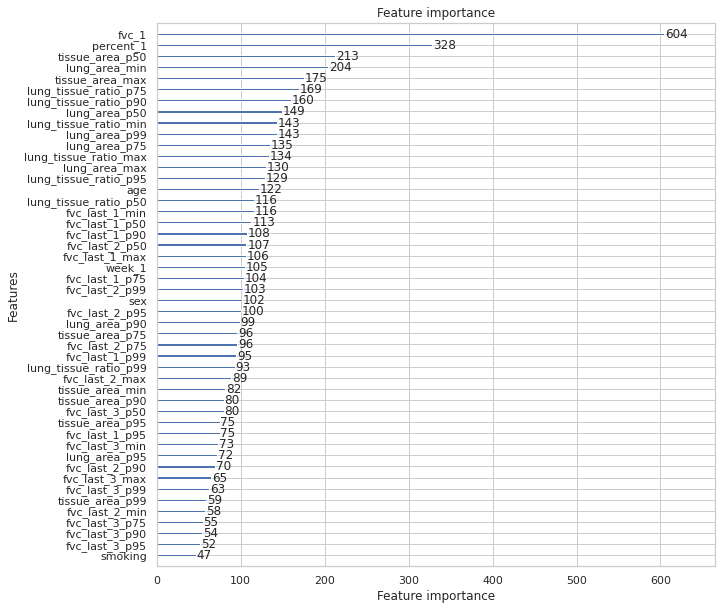

In [14]:
lgb.plot_importance(models[0].best_estimator_['model'], figsize=(10, 10))
    

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

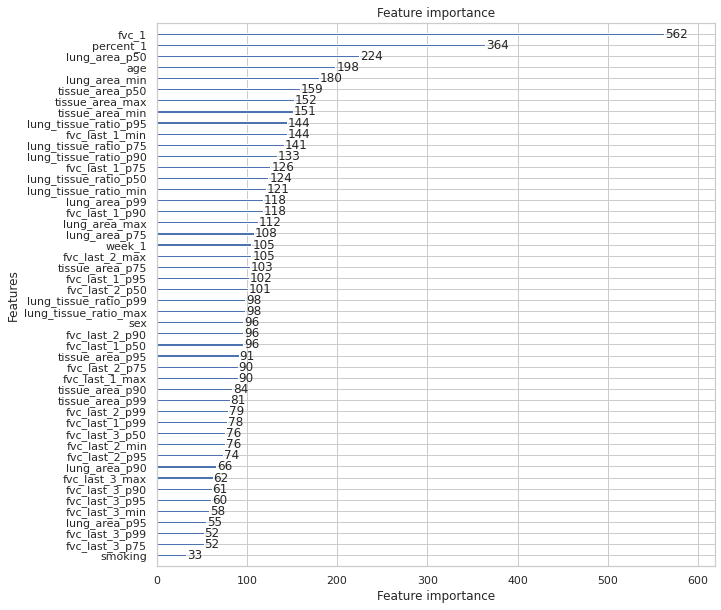

In [15]:
lgb.plot_importance(models[1].best_estimator_['model'], figsize=(10, 10))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

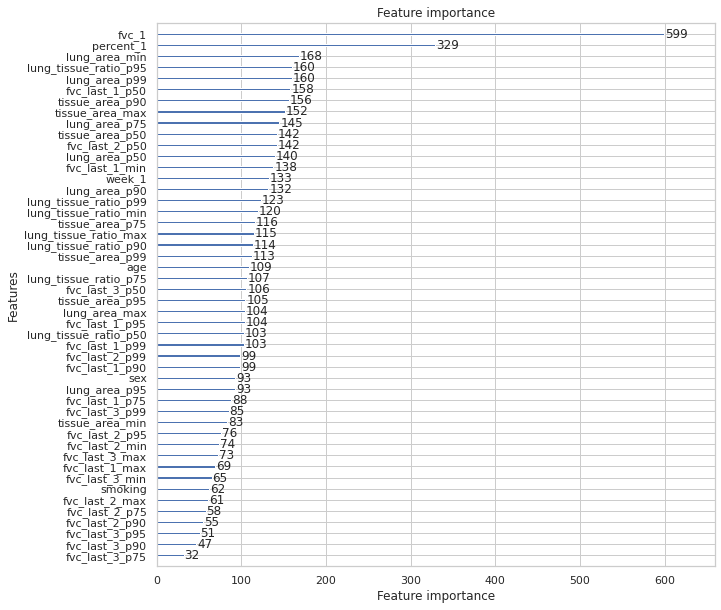

In [16]:
lgb.plot_importance(models[2].best_estimator_['model'], figsize=(10, 10))

In [17]:
for i in range(len(models)):
    y = TARGET[i]
    lgbm = models[i]
    lgbm.best_estimator_['model'].booster_.save_model(f'output/lgb_{y}.txt')